In [6]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D,
                                     Multiply, Reshape, BatchNormalization, MaxPooling2D)
from tensorflow.python.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding="same", activation="sigmoid")(concat)
    return Multiply()([inputs, attention])

In [4]:
def channel_attention(inputs):
    attention = GlobalAveragePooling2D()(inputs)
    attention = Dense(inputs.shape[-1] // 8, activation="relu")(attention)
    attention = Dense(inputs.shape[-1], activation="sigmoid")(attention)
    attention = Reshape((1, 1, inputs.shape[-1]))(attention)
    return Multiply()([inputs, attention])

In [5]:
def build_improved_densenet(input_shape=(224, 224, 3), num_classes=4):
    base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add attention mechanisms
    x = channel_attention(x)
    x = spatial_attention(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    # x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    # x = Dropout(0.7)(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.6)(x)

    # Output layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [4]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        shear_range=0.2,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [7]:
def train_model(model, train_generator, val_generator, epochs=30, learning_rate=1e-4, patience=3):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    early_stop = EarlyStopping(
        monitor='val_loss',   # you can also monitor 'val_categorical_accuracy'
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator,callbacks=[early_stop,reduce_lr])
    return history

In [8]:
def fine_tune_model(model, train_generator, val_generator, fine_tune_epochs=10, fine_tune_lr=1e-5):
    for layer in model.layers[:-100]:
        layer.trainable = False
    for layer in model.layers[-50:]:
        layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    history_fine = model.fit(train_generator, epochs=fine_tune_epochs, validation_data=val_generator)
    return history_fine

In [9]:
def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["categorical_accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_categorical_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

In [11]:
def main():
    set_seed()

    # Define dataset paths
    dataset_path = r"C:\Users\User\Desktop\Diseases\Dataset"
    train_dir = os.path.join(dataset_path, "train")
    val_dir = os.path.join(dataset_path, "val")
    test_dir = os.path.join(dataset_path, "test")

    # Create data generators
    train_generator, val_generator, test_generator = create_generators(train_dir, val_dir, test_dir)

    # Build model
    model = build_improved_densenet()

    # Train model
    history = train_model(model, train_generator, val_generator)
    plot_history(history)

    # Fine-tune model
    history_fine = fine_tune_model(model, train_generator, val_generator)
    plot_history(history_fine)

    # Evaluate model
    evaluate_model(model, test_generator)

    # Save model
    model.save("eyenet_model_52k_ds.h5")
    print("eyenet_model_52k_ds.h5")

Found 36462 images belonging to 4 classes.
Found 7812 images belonging to 4 classes.
Found 7820 images belonging to 4 classes.
Epoch 1/30
1140/1140 [==============================] - 238s 206ms/step - loss: 0.8314 - categorical_accuracy: 0.6379 - val_loss: 0.5540 - val_categorical_accuracy: 0.7794 - lr: 1.0000e-04
Epoch 2/30
1140/1140 [==============================] - 264s 231ms/step - loss: 0.5659 - categorical_accuracy: 0.7771 - val_loss: 0.4948 - val_categorical_accuracy: 0.8114 - lr: 1.0000e-04
Epoch 3/30
1140/1140 [==============================] - 267s 234ms/step - loss: 0.5006 - categorical_accuracy: 0.8090 - val_loss: 0.4671 - val_categorical_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 4/30
1140/1140 [==============================] - 267s 234ms/step - loss: 0.4665 - categorical_accuracy: 0.8218 - val_loss: 0.4256 - val_categorical_accuracy: 0.8369 - lr: 1.0000e-04
Epoch 5/30
1140/1140 [==============================] - 268s 235ms/step - loss: 0.4380 - categorical_accuracy: 0.8354

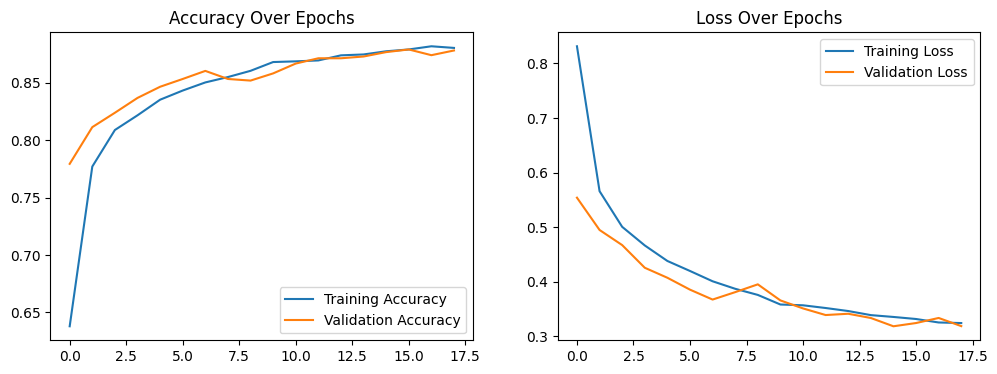

Epoch 1/10
1140/1140 [==============================] - 277s 238ms/step - loss: 0.2722 - categorical_accuracy: 0.9046 - val_loss: 0.1744 - val_categorical_accuracy: 0.9441
Epoch 2/10
1140/1140 [==============================] - 294s 257ms/step - loss: 0.1874 - categorical_accuracy: 0.9402 - val_loss: 0.1182 - val_categorical_accuracy: 0.9610
Epoch 3/10
1140/1140 [==============================] - 242s 212ms/step - loss: 0.1486 - categorical_accuracy: 0.9545 - val_loss: 0.1147 - val_categorical_accuracy: 0.9634
Epoch 4/10
1140/1140 [==============================] - 259s 227ms/step - loss: 0.1282 - categorical_accuracy: 0.9618 - val_loss: 0.0815 - val_categorical_accuracy: 0.9781
Epoch 5/10
1140/1140 [==============================] - 281s 246ms/step - loss: 0.1124 - categorical_accuracy: 0.9670 - val_loss: 0.0951 - val_categorical_accuracy: 0.9730
Epoch 6/10
1140/1140 [==============================] - 278s 244ms/step - loss: 0.1003 - categorical_accuracy: 0.9718 - val_loss: 0.0899 - v

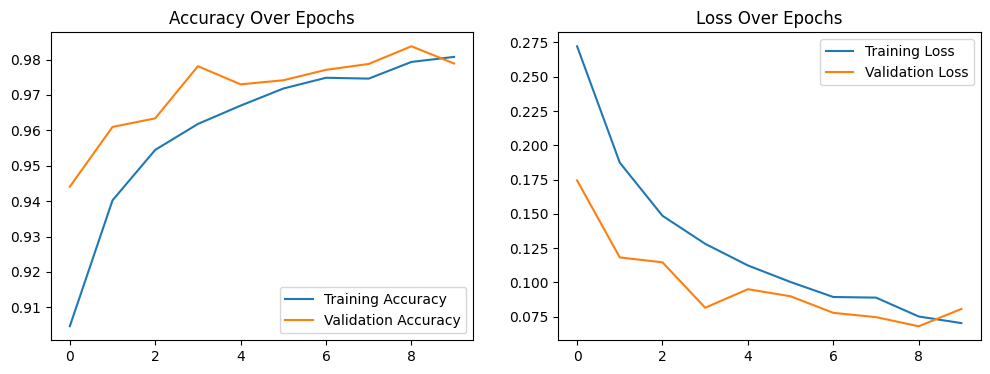

245/245 [==============================] - 15s 60ms/step - loss: 0.0734 - categorical_accuracy: 0.9792
Test Accuracy: 97.92%
245/245 [==============================] - 15s 57ms/step
                precision    recall  f1-score   support

      Cataract       0.97      0.98      0.98      1955
Conjunctivitis       0.96      0.99      0.98      1955
       Healthy       0.99      0.96      0.98      1955
          Stye       0.99      0.98      0.99      1955

      accuracy                           0.98      7820
     macro avg       0.98      0.98      0.98      7820
  weighted avg       0.98      0.98      0.98      7820



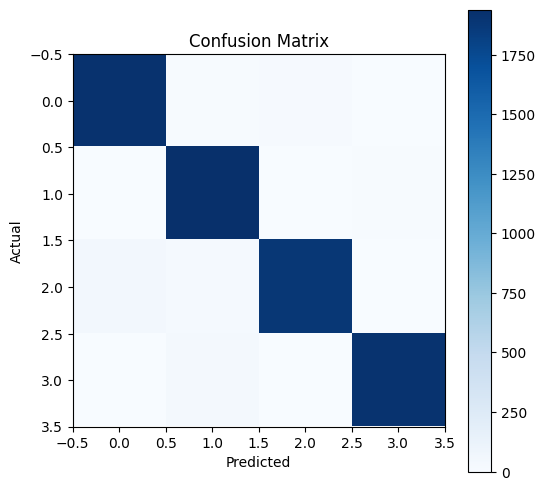

eyenet_model_52k_ds.h5


In [12]:
if __name__ == "__main__":
    main()

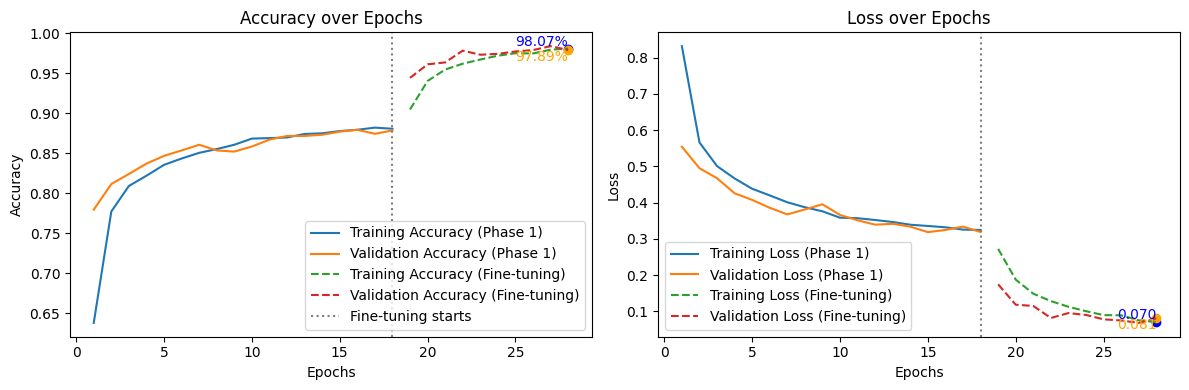

In [15]:
import matplotlib.pyplot as plt

# Data from logs
train_acc = [
    0.6379, 0.7771, 0.8090, 0.8218, 0.8354, 0.8433, 0.8504, 0.8551, 0.8605, 0.8682, 0.8688, 0.8696, 0.8740, 0.8748, 0.8776, 0.8792, 0.8819, 0.8805,
    0.9046, 0.9402, 0.9545, 0.9618, 0.9670, 0.9718, 0.9749, 0.9746, 0.9793, 0.9807
]

val_acc = [
    0.7794, 0.8114, 0.8240, 0.8369, 0.8466, 0.8534, 0.8605, 0.8534, 0.8520, 0.8583, 0.8669, 0.8715, 0.8715, 0.8730, 0.8769, 0.8792, 0.8742, 0.8783,
    0.9441, 0.9610, 0.9634, 0.9781, 0.9730, 0.9741, 0.9771, 0.9788, 0.9837, 0.9789
]

train_loss = [
    0.8314, 0.5659, 0.5006, 0.4665, 0.4380, 0.4197, 0.4008, 0.3870, 0.3758, 0.3582, 0.3568, 0.3518, 0.3463, 0.3388, 0.3354, 0.3317, 0.3253, 0.3243,
    0.2722, 0.1874, 0.1486, 0.1282, 0.1124, 0.1003, 0.0894, 0.0889, 0.0752, 0.0703
]

val_loss = [
    0.5540, 0.4948, 0.4671, 0.4256, 0.4073, 0.3855, 0.3673, 0.3809, 0.3952, 0.3657, 0.3511, 0.3390, 0.3413, 0.3335, 0.3184, 0.3243, 0.3336, 0.3187,
    0.1744, 0.1182, 0.1147, 0.0815, 0.0951, 0.0899, 0.0778, 0.0747, 0.0680, 0.0806
]
split_epoch = 18  # where fine-tuning starts

epochs = list(range(1, len(train_acc) + 1))
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs[:split_epoch], train_acc[:split_epoch], label="Training Accuracy (Phase 1)")
plt.plot(epochs[:split_epoch], val_acc[:split_epoch], label="Validation Accuracy (Phase 1)")
plt.plot(epochs[split_epoch:], train_acc[split_epoch:], '--', label="Training Accuracy (Fine-tuning)")
plt.plot(epochs[split_epoch:], val_acc[split_epoch:], '--', label="Validation Accuracy (Fine-tuning)")
plt.axvline(split_epoch, color='gray', linestyle=':', label='Fine-tuning starts')

# Final points
plt.scatter(epochs[-1], train_acc[-1], color='blue', marker='o')
plt.scatter(epochs[-1], val_acc[-1], color='orange', marker='o')
plt.text(epochs[-1], train_acc[-1], f'{train_acc[-1]*100:.2f}%', color='blue', ha='right', va='bottom')
plt.text(epochs[-1], val_acc[-1], f'{val_acc[-1]*100:.2f}%', color='orange', ha='right', va='top')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs[:split_epoch], train_loss[:split_epoch], label="Training Loss (Phase 1)")
plt.plot(epochs[:split_epoch], val_loss[:split_epoch], label="Validation Loss (Phase 1)")
plt.plot(epochs[split_epoch:], train_loss[split_epoch:], '--', label="Training Loss (Fine-tuning)")
plt.plot(epochs[split_epoch:], val_loss[split_epoch:], '--', label="Validation Loss (Fine-tuning)")
plt.axvline(split_epoch, color='gray', linestyle=':')

# Final points
plt.scatter(epochs[-1], train_loss[-1], color='blue', marker='o')
plt.scatter(epochs[-1], val_loss[-1], color='orange', marker='o')
plt.text(epochs[-1], train_loss[-1], f'{train_loss[-1]:.3f}', color='blue', ha='right', va='bottom')
plt.text(epochs[-1], val_loss[-1], f'{val_loss[-1]:.3f}', color='orange', ha='right', va='top')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

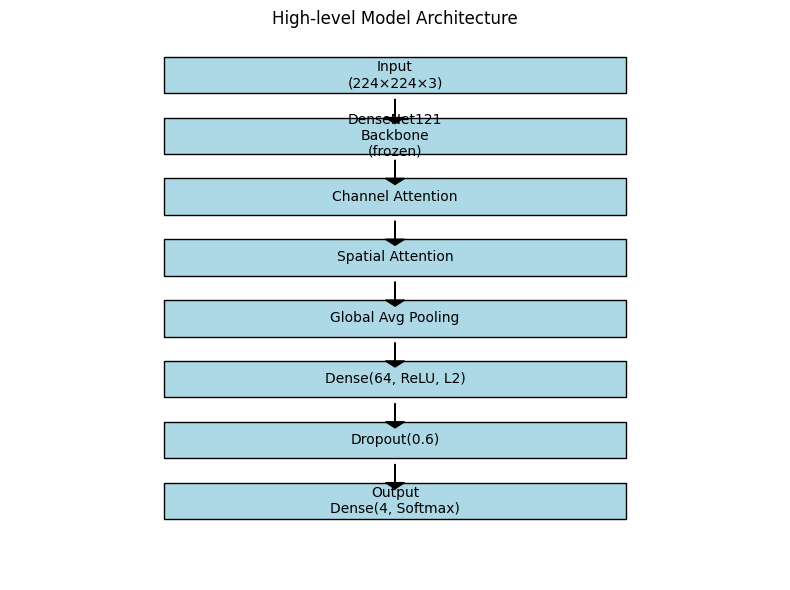

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

layers = [
    "Input\n(224×224×3)",
    "DenseNet121\nBackbone\n(frozen)",
    "Channel Attention",
    "Spatial Attention",
    "Global Avg Pooling",
    "Dense(64, ReLU, L2)",
    "Dropout(0.6)",
    "Output\nDense(4, Softmax)"
]

y_positions = list(range(len(layers)))[::-1]

for y, layer in zip(y_positions, layers):
    ax.add_patch(plt.Rectangle((0.4, y), 1.2, 0.6, edgecolor='black', facecolor='lightblue'))
    ax.text(1, y+0.3, layer, ha='center', va='center', fontsize=10)

for i in range(len(layers)-1):
    ax.arrow(1, y_positions[i]-0.1, 0, -0.3, head_width=0.05, head_length=0.1, fc='black', ec='black')

ax.set_xlim(0, 2)
ax.set_ylim(-1, len(layers))
ax.axis('off')
plt.title("High-level Model Architecture", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import os
model_path = "eyenet_model_52k_ds.h5"
model = load_model(model_path)

# Define dataset paths
dataset_path = r"C:\Users\User\Desktop\Diseases\Dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Create data generators
train_generator, val_generator, test_generator = create_generators(train_dir, val_dir, test_dir)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

Found 36462 images belonging to 4 classes.
Found 7812 images belonging to 4 classes.
Found 7820 images belonging to 4 classes.
245/245 [==============================] - 12s 44ms/step
[[1923   14   18    0]
 [   3 1940    2   10]
 [  50   23 1882    0]
 [   1   41    1 1912]]


In [10]:
import numpy as np
import pandas as pd

cm = np.array([
    [1923, 14, 18, 0],
    [3, 1940, 2, 10],
    [50, 23, 1882, 0],
    [1, 41, 1, 1912]
])

total = cm.sum()
per_class_total = cm.sum(axis=1)

results = []

for i, label in enumerate(['Healthy', 'Cataract', 'Conjunctivitis', 'Stye']):
    TP = cm[i, i]
    FN = per_class_total[i] - TP
    FP = cm[:, i].sum() - TP
    TN = total - (TP + FP + FN)

    accuracy = (TP + TN) / total * 100
    TPR = TP / (TP + FN) * 100
    FNR = FN / (TP + FN) * 100
    FPR = FP / (FP + TN) * 100
    TNR = TN / (FP + TN) * 100
    precision = TP / (TP + FP) * 100
    f1 = 2 * precision * TPR / (precision + TPR)

    results.append([
        label,
        round(accuracy, 3),
        round(TPR, 3),
        round(FNR, 3),
        round(FPR, 3),
        round(TNR, 3),
        round(precision, 3),
        round(f1, 3)
    ])

df = pd.DataFrame(results, columns=[
    'Class', 'Accuracy(%)', 'TPR(%)', 'FNR(%)', 'FPR(%)', 'TNR(%)', 'Precision(%)', 'F1 Score(%)'
])

print(df.to_markdown(index=False))

| Class          |   Accuracy(%) |   TPR(%) |   FNR(%) |   FPR(%) |   TNR(%) |   Precision(%) |   F1 Score(%) |
|:---------------|--------------:|---------:|---------:|---------:|---------:|---------------:|--------------:|
| Healthy        |        98.9   |   98.363 |    1.637 |    0.921 |   99.079 |         97.269 |        97.813 |
| Cataract       |        98.811 |   99.233 |    0.767 |    1.33  |   98.67  |         96.135 |        97.659 |
| Conjunctivitis |        98.798 |   96.266 |    3.734 |    0.358 |   99.642 |         98.896 |        97.564 |
| Stye           |        99.322 |   97.801 |    2.199 |    0.171 |   99.829 |         99.48  |        98.633 |
